# Assignment 1 - Multi View Geometry

Team Ironix:
<br>
Iva Ilcheva - ilchei@usi.ch<br>
Reinard Lazuardi Kuwandy - kuwanr@usi.ch

### Required files
#### Please make sure these file are in the same folder as this notebook

* epiplarWrks.mat
* utils.py

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from random import randrange
%matplotlib inline

In [2]:
from utils import select_points, draw_line

In [3]:
from scipy.io import loadmat

### Load Data and save them in variables

In [4]:
try:
    my_workspace = loadmat("epipolarWrks.mat")
except:
    print("epiplarWrks.mat file is not found")

In [5]:
import pprint



# Part 1
imgV1 = my_workspace["imgV1"]
imgV2 = my_workspace["imgV2"]
X1 = my_workspace["X12"][0:3]
X2 = my_workspace["X12"][3:6]

# Part 2
imgS1 = my_workspace["imgS1"]
imgS2 = my_workspace["imgS2"]
imgS3gray = my_workspace["imgS3gray"]
X1s = my_workspace["X12s"][0:3]
X2s = my_workspace["X12s"][3:6]
F13 = my_workspace["F13"]
F23 = my_workspace["F23"]


## debug printing
# pprint.pprint(my_workspace)
# print(F13)
# print(F23)
# plt.imshow(imgS3gray)
# plt.show()

## Part 1

### Estimate Fundamental Matrix

In [6]:
def fundamental_matrix(x1,x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3 x n arrays) using the 8 point algorithm.
        
        input:  x1 : corresponding points in image 1 [3 x n]
                x2 : corresponding points in image 2 [3 x n]
        
        output: F : normalized fundamental matrix [3x3]
        
    """
    
    # preprocessing and validation
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    # A[i] = [x'x, x'y, x', y'x, y'y, y', x, y, 1]
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i],
                x2[0,i], x2[1,i], 1 ]
            
    # compute linear least square solution
    # DLT Algorithm
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    # F = UD(2)V'
    S[2] = 0
    # F = UDV'
    F = np.dot(U,np.dot(np.diag(S),V))
    
    # normalize and return F
    return F/F[2,2]

In [7]:
def estimate_fundamental_matrix(x1,x2):
    """ Estimate the fundamental matrix from corresponding points
        
        input:  x1 : corresponding points in image 1 [3 x n]
                x2 : corresponding points in image 2 [3 x n]
        
        output: F : estimation of fundamental matrix [3x3]
    
    """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    # preconditioning for a set of points x1 and compute Tx1
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.std(x1[:2]) / np.sqrt(2)
    T1 = np.array([[1/S1,0,-mean_1[0]/S1],[0,1/S1,-mean_1[1]/S1],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    # preconditioning for a set of points x2 and compute Tx2
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.std(x2[:2]) / np.sqrt(2)
    T2 = np.array([[1/S2,0,-mean_2[0]/S2],[0,1/S2,-mean_2[1]/S2],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = fundamental_matrix(x1,x2)

    # reverse normalization -> F = T'.t * F * T
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [8]:
F1 = fundamental_matrix(X1, X2)
print("Fundamental matrix 1:")
print(F1)
print("\n")

# to show the transpose relations with F1
F2 = fundamental_matrix(X2, X1)
print("Fundamental matrix 2:")
print(F2)
print("\n")

## Estimate the fundamental matrix mapping imgV1 in imgV2
Estimation_F = estimate_fundamental_matrix(X1,X2)
print("Estimation fundamental matrix mapping:")
print(Estimation_F)

Fundamental matrix 1:
[[ 7.71236816e-08  3.81741218e-07 -2.83081439e-03]
 [-1.17061548e-07  4.85023740e-08 -7.24247262e-03]
 [ 2.29765887e-03  6.72912298e-03  1.00000000e+00]]


Fundamental matrix 2:
[[ 7.71236816e-08 -1.17061548e-07  2.29765887e-03]
 [ 3.81741218e-07  4.85023740e-08  6.72912298e-03]
 [-2.83081439e-03 -7.24247262e-03  1.00000000e+00]]


Estimation fundamental matrix mapping:
[[ 8.13224250e-08 -7.65191208e-08 -2.37250074e-03]
 [ 4.11701002e-07 -3.33769529e-08 -1.04612374e-02]
 [ 1.73663780e-03  1.01677757e-02  1.00000000e+00]]


### Calculate Epipole

In [9]:
def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        
        Input : F = Fundamental Matrix [3x3]
        
        Output: e = normalized epipole [1x3]
    
    """
    
    # return null space of F
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

In [10]:
e1 = compute_epipole(F1)
print("epipole F1 : ")
print(e1)
print("\n")

e2 = compute_epipole(F2)
print("epipole F2 : ")
print(e2)

epipole F1 : 
[-5.42548641e+04  1.83767142e+04  1.00000000e+00]


epipole F2 : 
[-1.85670547e+04  7.39524863e+03  1.00000000e+00]


### Plot Epipole line imgV1 and imgV2

In [11]:
def plot_points(im,F,x ,x_plot, epipole=None, show_epipole=False):
    """plot epipole lines or epipole
    
    Input : im = image 
            F = fundamental matrix
            x = corresponding points from other images
            x_plot = correspoinding points of images im
            epipole = epipole of image im
            show_epipole = binary parameter to show epipole
    
    Output : None (show the image)
    
    """
    
    # enlarge the plot size and plot image im
    plt.subplots(1, 1, figsize = (12, 10))
    plt.imshow(im)
    
    # if want to plot epipole
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        e = [epipole[0]/epipole[2],epipole[1]/epipole[2]]
        plt.plot(e[0],e[1], 'r*')
        plt.text(e[0],e[1], "({:.2f},{:.2f})".format(e[0],e[1]))
    
    # if want to plot epipole lines
    else:
        
        # color variables
        x_points = np.arange(10)
        ys = [i+x_points+(i*x_points)**2 for i in range(10)]
        
        colors = cm.rainbow(np.linspace(0, 1, len(ys)))

        # img and calculate line -> l' = F * x or l = F.t * x'
        m, n = im.shape[:2]
        line = np.dot(F,x)
        
        # create points to create line
        t = np.linspace(0,n,1000)
        lt = np.array([-(line[2]+line[0]*tt)/(line[1]) for tt in t])
        lt_tp = np.transpose(lt)

        # plot the line and points
        for i in range(len(x_plot[0])):
            cur_color = colors[randrange(10)]
            plt.plot(x_plot[0][i], x_plot[1][i], 'o', color=cur_color, markersize=10)
            plt.plot(t, lt_tp[i], color = cur_color, linewidth=2 )
    
    plt.show()

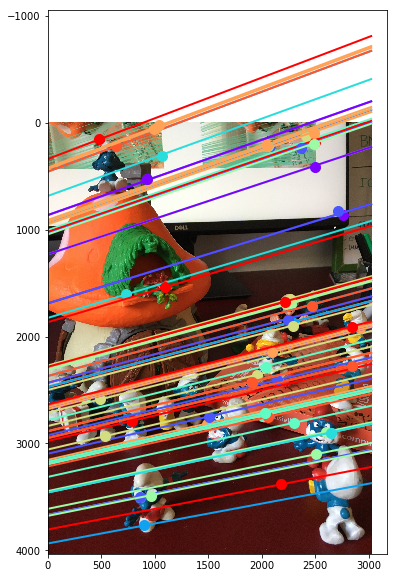

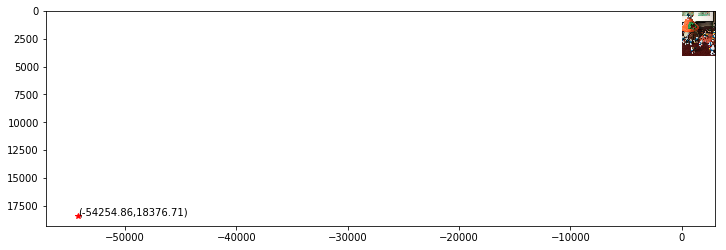

In [12]:
%matplotlib inline
plot_points(imgV1,F1,X2, X1)
## show epipoles
plot_points(imgV1,F1,X2, X1, e1, True)

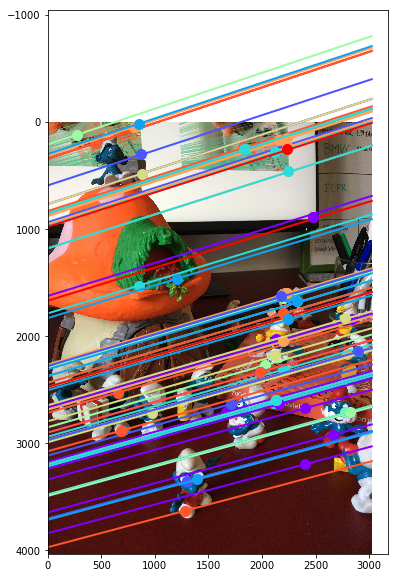

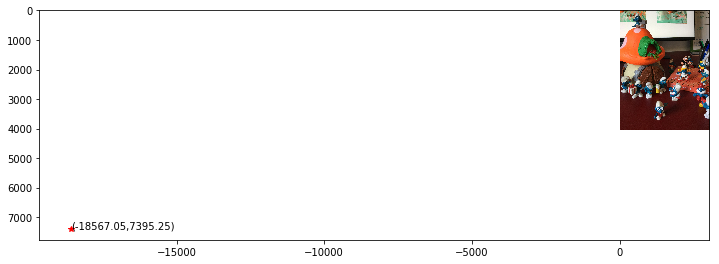

In [13]:
plot_points(imgV2,F2,X1, X2)
## show epipoles
plot_points(imgV2,F2,X1, X2, e2, True)
## can be
# plot_points(imgV2,np.transpose(F1),X1, X2)

## Part 2

### Select points manually from image S1 and S2

In [14]:
%matplotlib tk
## Since select points utils have problem we defined it manually
pts1 = [ 68.26547553, 117.89072848, 1]

# pts = select_points(imgS2, 1)
# print(pts)
pts2 = [ 74.76841887, 114.17476085, 1]


pts3 = [ 45.47033664, 164.34032377, 1]
pts4 = [ 65.38560063, 157.83738043, 1]

pts5, pts6 = [], []
## For selecting correspondent points manually
## Please uncomment the code below if you want to try select manually corespondent points
# fig,ax = plt.subplots(1, 1, figsize = (10, 10))
# fig.suptitle('imgS1', fontsize=14, fontweight='bold')
# tmp_pts5 = select_points(imgS1, 1)
# print(tmp_pts5)
# pts5 = list(tmp_pts5[0])
# pts5.append(1)

# fig,ax = plt.subplots(1, 1, figsize = (10, 10))
# fig.suptitle('imgS2', fontsize=14, fontweight='bold')
# tmp_pts6 = select_points(imgS2, 1)
# print(tmp_pts6)
# pts6 = list(tmp_pts6[0])
# pts6.append(1)

In [15]:
%matplotlib inline
def plot_points2(im,F13,x1, F23, x2, plot_line=True, imS1=None):
    """plot epipole lines or epipole
    
    Input : im = image 
            F13 = fundamental matrix F13
            x1 = point of from img S1
            F23 = fundamental matrix F23
            x2 = point of from img S2
            plot_line = binary plot line vars
            imS1 = image S1
    
    Output : None (show the image)
    
    """
    
    # enlarge the plot size and plot image im
    plt.subplots(1, 1, figsize = (12, 10))
#     plt.axis([0, 200, 200, 0])
    
    # color variables
    x_points = np.arange(10)
    ys = [i+x_points+(i*x_points)**2 for i in range(10)]

    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    # img and calculate line -> l' = F * x or l = F.t * x'
    m, n = im.shape[:2]
    line1 = np.dot(F13,x1)
    line2 = np.dot(F23,x2)
    
    # create points to create line pts1
    t1 = np.linspace(0,n+100,1000)
    lt1 = np.array([-(line1[2]+line1[0]*tt)/(line1[1]) for tt in t1])
    
    # create points to create line pts2
    t2 = np.linspace(0,n+100,1000)
    lt2 = np.array([-(line2[2]+line2[0]*tt)/(line2[1]) for tt in t2])
    
    if imS1 is not None or plot_line:
        I = np.dstack([im, im, im])
        I[np.logical_and(np.logical_and(I[:, :, 0]==15, I[:, :, 1]==15), I[:, :, 2]==15)] = [0, 1, 0]
    else:
        I = im
    
    if plot_line:
        plt.imshow(I)
        
        # plot line
        plt.plot(t1, lt1, 'r')
        plt.plot(t2, lt2, 'b')
        
        # Find intersection between 2 lines
        idx = np.argwhere(np.diff(np.sign(lt1 - lt2))).flatten()
        plt.plot(t1[idx], lt1[idx], 'wo', markersize=10)
    else:
        plt.imshow(I)
        lt1_tp = np.transpose(lt1)
        lt2_tp = np.transpose(lt2)
        
        ii = lt1_tp.shape[0]
        
        for i in range(ii):
        
            # get intersection points index
            idx = np.argwhere(np.diff(np.sign(lt1_tp[i] - lt2_tp[i]))).flatten()

            try:
                y = int(t1[idx])
                x = int(lt1_tp[i][idx])
            except:
                print(t1[idx])
                print(x)

            if imS1 is not None:
                try:
                    I[x - 2:x+4, y-2:y+4, :] = imS1[x, y]

                except Exception as e:
                    print(e)
                    print("Error")

            if imS1 is None:
                plt.plot(t1[idx], lt1_tp[i][idx],'wo', markersize=10)

    plt.imshow(I)
    plt.show()
    

In [16]:
%matplotlib inline
def plot_points3(im,F13,x1, F23, x2):
    """plot epipole lines or epipole
    
    Input : im = image 
            F13 = fundamental matrix F13
            x1 = point of from img S1
            F23 = fundamental matrix F23
            x2 = point of from img S2
            plot_line = binary plot line vars
            imS1 = image S1
    
    Output : None (show the image)
    
    """
    
    # enlarge the plot size and plot image im
    plt.subplots(1, 1, figsize = (12, 10))
    
    # color variables
    x_points = np.arange(10)
    ys = [i+x_points+(i*x_points)**2 for i in range(10)]

    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    # img and calculate line -> l' = F * x or l = F.t * x'
    m, n = im.shape[:2]
    line1 = np.dot(F13,x1)
    line2 = np.dot(F23,x2)
    
    # create points to create line pts1
    t1 = np.linspace(0,n+100,1000)
    lt1 = np.array([-(line1[2]+line1[0]*tt)/(line1[1]) for tt in t1])
    
    # create points to create line pts2
    t2 = np.linspace(0,n+100,1000)
    lt2 = np.array([-(line2[2]+line2[0]*tt)/(line2[1]) for tt in t2])
    
    I = im

    # plot line
#     plt.plot(t1, lt1, 'r')
#     plt.plot(t2, lt2, 'b')
    lt1_transpose = np.transpose(lt1)
    lt2_transpose = np.transpose(lt2)

    # Find intersection between 2 lines
    for i in range(lt1_transpose.shape[0]):
        idx = np.argwhere(np.diff(np.sign(lt1_transpose[i] - lt2_transpose[i]))).flatten()
        plt.plot(t2[idx], lt2_transpose[i][idx], 'wo', markersize=10)
    
    plt.imshow(I)
    plt.show()
    

### Peform epipolar transfer between imgS1 and imgS2 to imgS3gray

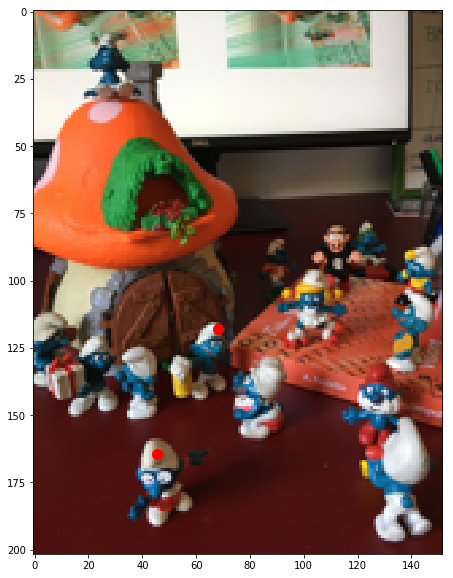

In [17]:
%matplotlib inline
## show point1 on imgS1
plt.subplots(1, 1, figsize = (12, 10))
plt.imshow(imgS1)
plt.plot(pts1[0], pts1[1], 'ro', markersize=10)
plt.plot(pts3[0], pts3[1], 'ro', markersize=10)
if len(pts5) > 0:
    plt.plot(pts5[0], pts5[1], 'ro', markersize=10)
plt.show()

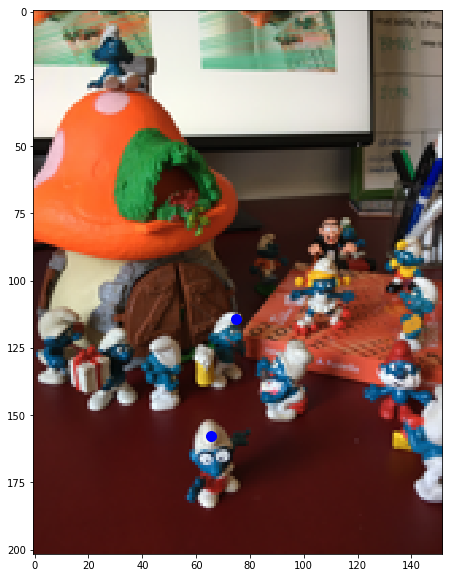

In [18]:
%matplotlib inline
## show point2 on imgS2
plt.subplots(1, 1, figsize = (12, 10))
plt.imshow(imgS2)
plt.plot(pts2[0], pts2[1], 'bo', markersize=10)
plt.plot(pts4[0], pts4[1], 'bo', markersize=10)
if len(pts6) > 0:
    plt.plot(pts6[0], pts6[1], 'bo', markersize=10)
plt.show()

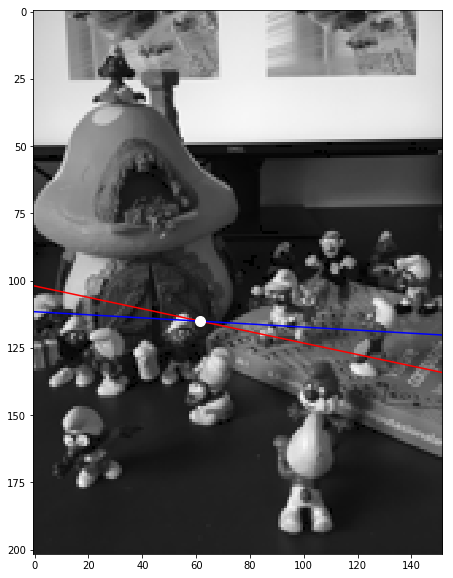

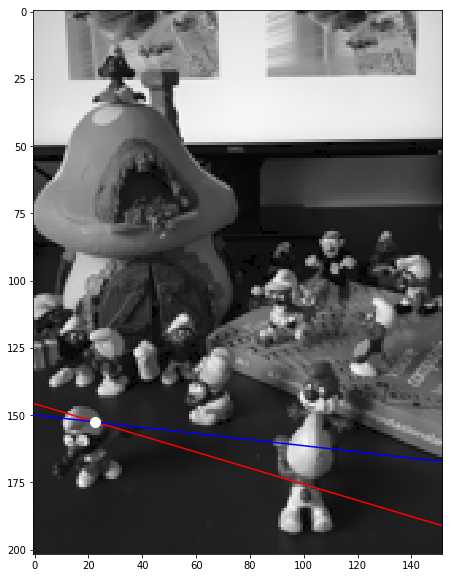

In [19]:
## plot points which intersect the epipolar transfer line
plot_points2(imgS3gray,F13,pts1, F23, pts2, True, )
plot_points2(imgS3gray,F13,pts3, F23, pts4, True, )
if len(pts5) > 0 and len(pts6) > 0:
    plot_points2(imgS3gray,F13,pts5, F23, pts6, True, )

### Add colors from imgS1 to ​imgS3gray​ by means of epipolar transfer of the matches ​X12s​.

In [20]:
## Unused
## Estimate the fundamental matrix mapping imgV1 in imgV2
F1s = fundamental_matrix(X1s, X2s)
print(F1s)

# to show the transpose relations with F1
F2s = fundamental_matrix(X2s, X1s)
print(F2s)

[[ 3.09797190e-05  1.41436782e-04 -5.60884881e-02]
 [-3.39568792e-05  1.74617068e-05 -1.48792217e-01]
 [ 4.53184993e-02  1.38772951e-01  1.00000000e+00]]
[[ 3.09797190e-05 -3.39568792e-05  4.53184993e-02]
 [ 1.41436782e-04  1.74617068e-05  1.38772951e-01]
 [-5.60884881e-02 -1.48792217e-01  1.00000000e+00]]


index 154 is out of bounds for axis 1 with size 152
Error
index 170 is out of bounds for axis 1 with size 152
Error


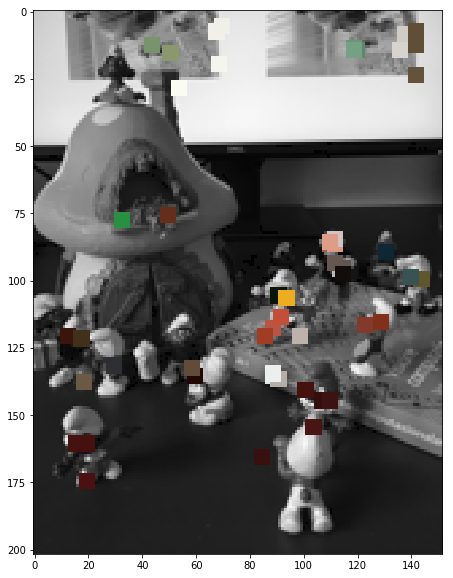

In [21]:
##select neighbor size of each epipolar transfer and paste with color pixels from imgS1
plot_points2(imgS3gray,F13,X1s, F23, X2s, False, imgS1)

## show points of epipolar transfer in imgS1
# plot_points3(imgS1,F13,X1s, F23, X2s)

We picked the pixels color from imgS1 which correspondence to the imgS3gray</br>

There are 2 epipolar transfer points which are outside of the image